# **Hypothesis 2 - Weather Conditions Affect Pollutant Levels**

## Objectives

* To assess hypothesis 2 - weather condition affects pollutant levels

## Inputs

* The csv file "pollution_us_2012_2016-population-weather.csv" 

## Outputs

* Results from hypothesis testing

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Air_Pollution_Team_2\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [17]:
os.chdir(r"c:\Users\sonia\Documents\VS Studio Projects\US_Air_Pollution_Team_2")

os.getcwd()

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Air_Pollution_Team_2'

Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Air_Pollution_Team_2'

---

# Required Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import normaltest
import pingouin as pg

---

## Load the Dataset

I will load the dataset using Pandas.

In [5]:
df = pd.read_csv('Dataset/EDA/pollution_us_2012_2016-population-weather.csv') # Reading the CSV file
pd.set_option("display.max_columns", None)
df.head()


,Address,State,County,City,Date Local,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,Population,Latitude,Longitude,tmax,prcp,wspd
0,400 W RIVER ROAD,Arizona,Pima,Tucson,2012-01-01,17.716667,31.0,0,29,0.013667,0.030,10,25,0.254167,0.5,19,0.0,0.336842,0.6,5,7.0,"542,649",31.9681,-111.7806,26.7,0.0,17.6
1,400 W RIVER ROAD,Arizona,Pima,Tucson,2012-01-02,15.062500,30.6,18,28,0.015083,0.030,10,25,0.200000,0.6,19,0.0,0.225000,0.4,23,5.0,"542,649",31.9681,-111.7806,24.4,0.0,27.4
2,400 W RIVER ROAD,Arizona,Pima,Tucson,2012-01-03,21.643478,31.0,18,29,0.011417,0.026,9,22,0.295455,0.7,8,0.0,0.295833,0.4,0,5.0,"542,649",31.9681,-111.7806,26.1,0.0,10.8
3,400 W RIVER ROAD,Arizona,Pima,Tucson,2012-01-04,25.041668,37.8,10,35,0.009208,0.020,10,17,0.737500,2.1,19,3.0,0.345833,0.5,12,6.0,"542,649",31.9681,-111.7806,24.4,0.0,9.0
4,400 W RIVER ROAD,Arizona,Pima,Tucson,2012-01-05,21.981817,37.1,17,35,0.013042,0.031,9,26,0.330435,0.8,21,0.0,0.291667,0.6,23,7.0,"542,649",31.9681,-111.7806,23.9,0.0,9.7


In [6]:
df['Date Local'] = pd.to_datetime(df['Date Local'])

In [7]:
df['Population'] = df['Population'].str.replace(',', '').astype(int)

---

## Correlations Between Pollutants and Weather

During EDA, I found that maximum temperature, precipitation and wind speed could all affect pollutant levels. However, the relationships are not linear (see below).

Therefore, I am going to bin each of the weather conditions into low, medium or high values, and then test changes in distribution for the mean and maximum value of each pollutant.

Below is a recap of what was shown in the EDA.

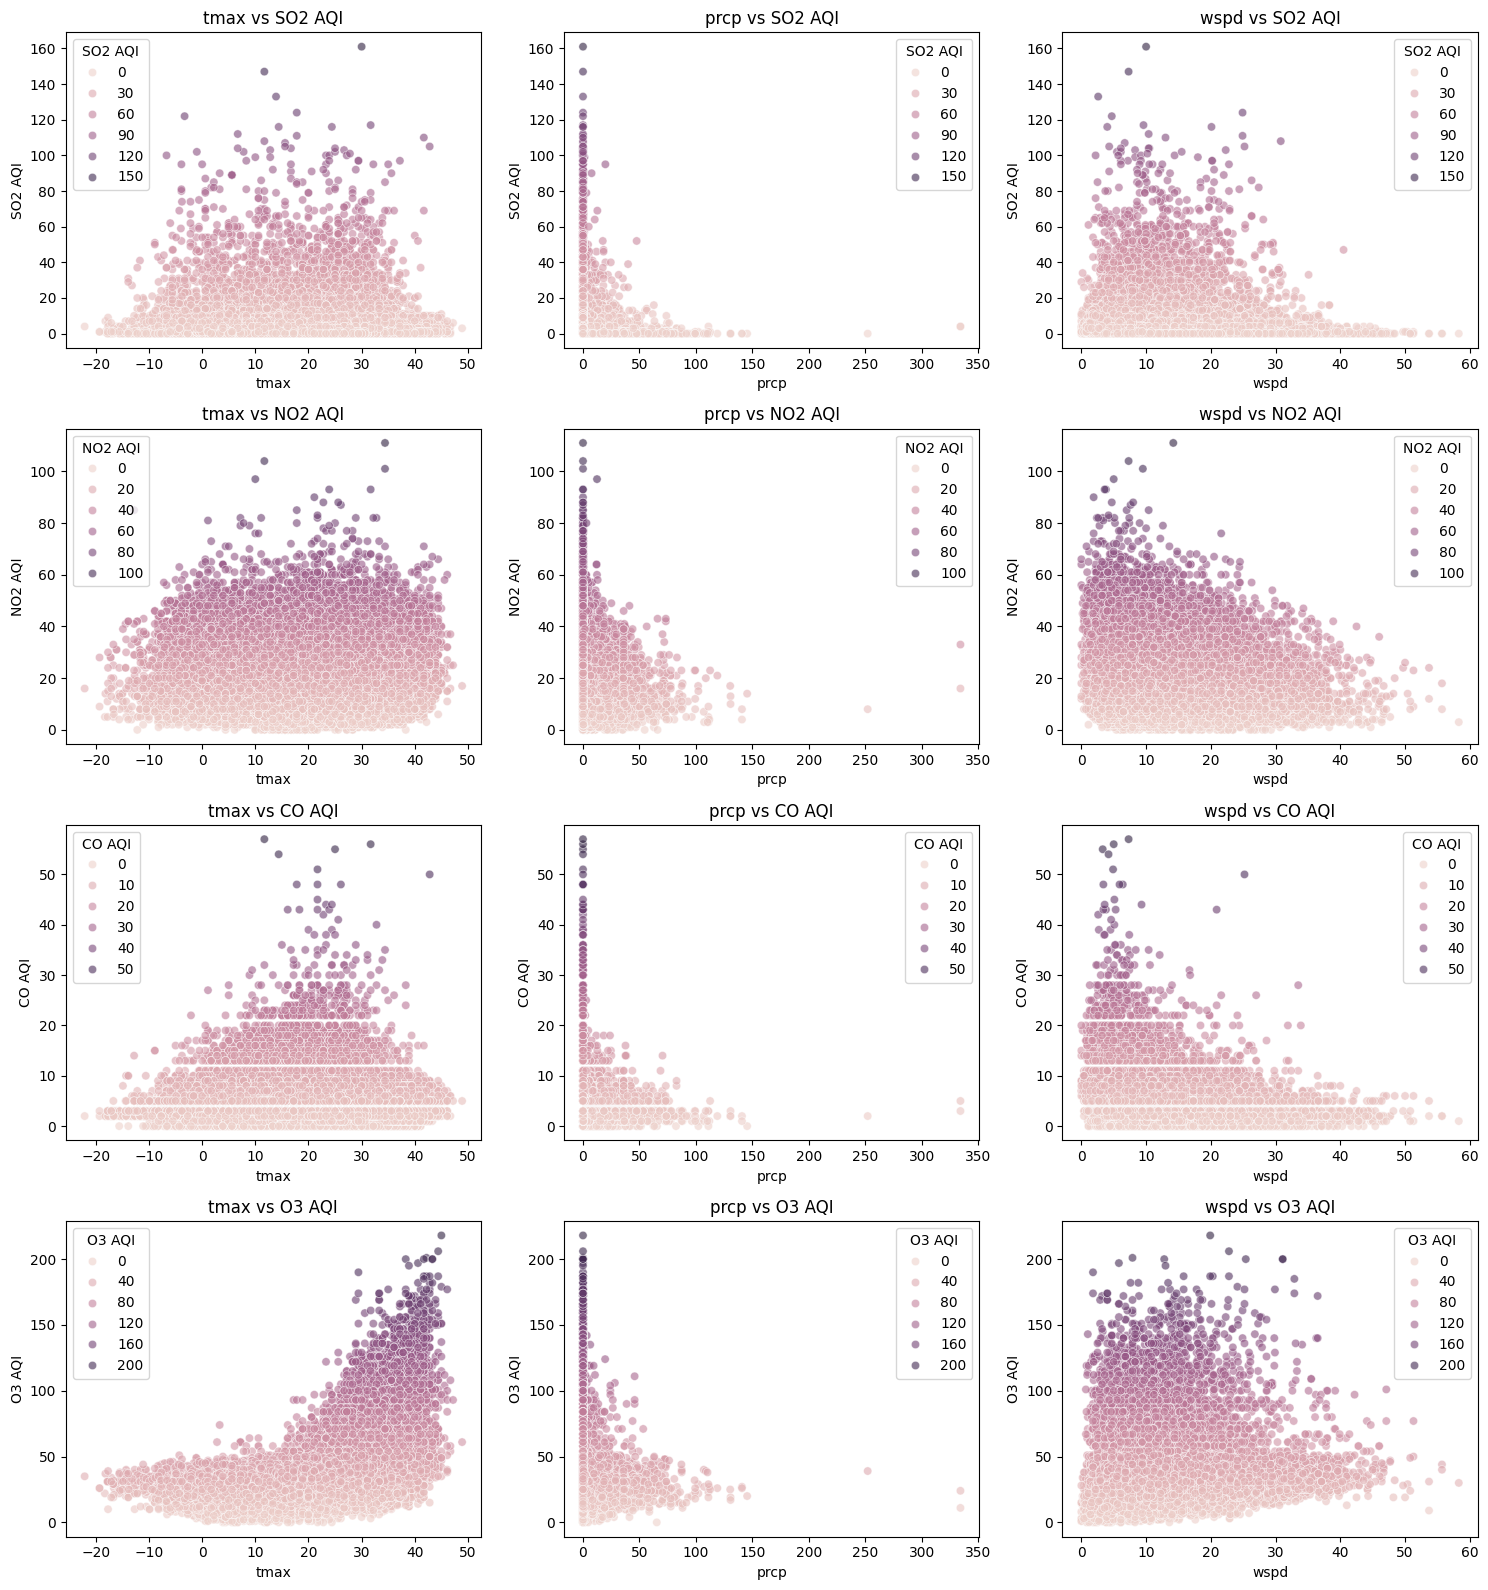

In [10]:
# Define your x and y variable sets
y_cols = ["SO2 AQI", "NO2 AQI", "CO AQI", "O3 AQI"]
x_cols = ["tmax", "prcp", "wspd"]  # 3 x-variables per y

# Calculate total number of plots
n = len(y_cols) * len(x_cols)
ncols = 3  # since 3 x-variables per y
nrows = len(y_cols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

idx = 0
for y_col in y_cols:
    for x_col in x_cols:
        sns.scatterplot(
            x=x_col,
            y=y_col,
            data=df,
            hue=y_col,
            alpha=0.6,
            ax=axes[idx]
        )
        axes[idx].set_title(f"{x_col} vs {y_col}")
        axes[idx].set_xlabel(x_col)
        axes[idx].set_ylabel(y_col)
        idx += 1

# Hide unused subplots if any
for j in range(idx, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

---

## Pollutant Levels and Maximum Temperature

Here, I am binning maximum temperature (tmax) into "Low" (-20 to 10 C), "Moderate" (0 to 25 C) and "High" (25 to 50 C), and creating a new column for the results. These bins were chosen based on what is intuitive for most people based on temperate climates.

In [13]:
bins = [-20, 10, 25, 50]
labels = ["Low", "Moderate", "High"]

df["tmax_bin"] = pd.cut(df["tmax"], bins=bins, labels=labels, include_lowest=True)

Then, I plot pollutant mean values by their tmax bins.

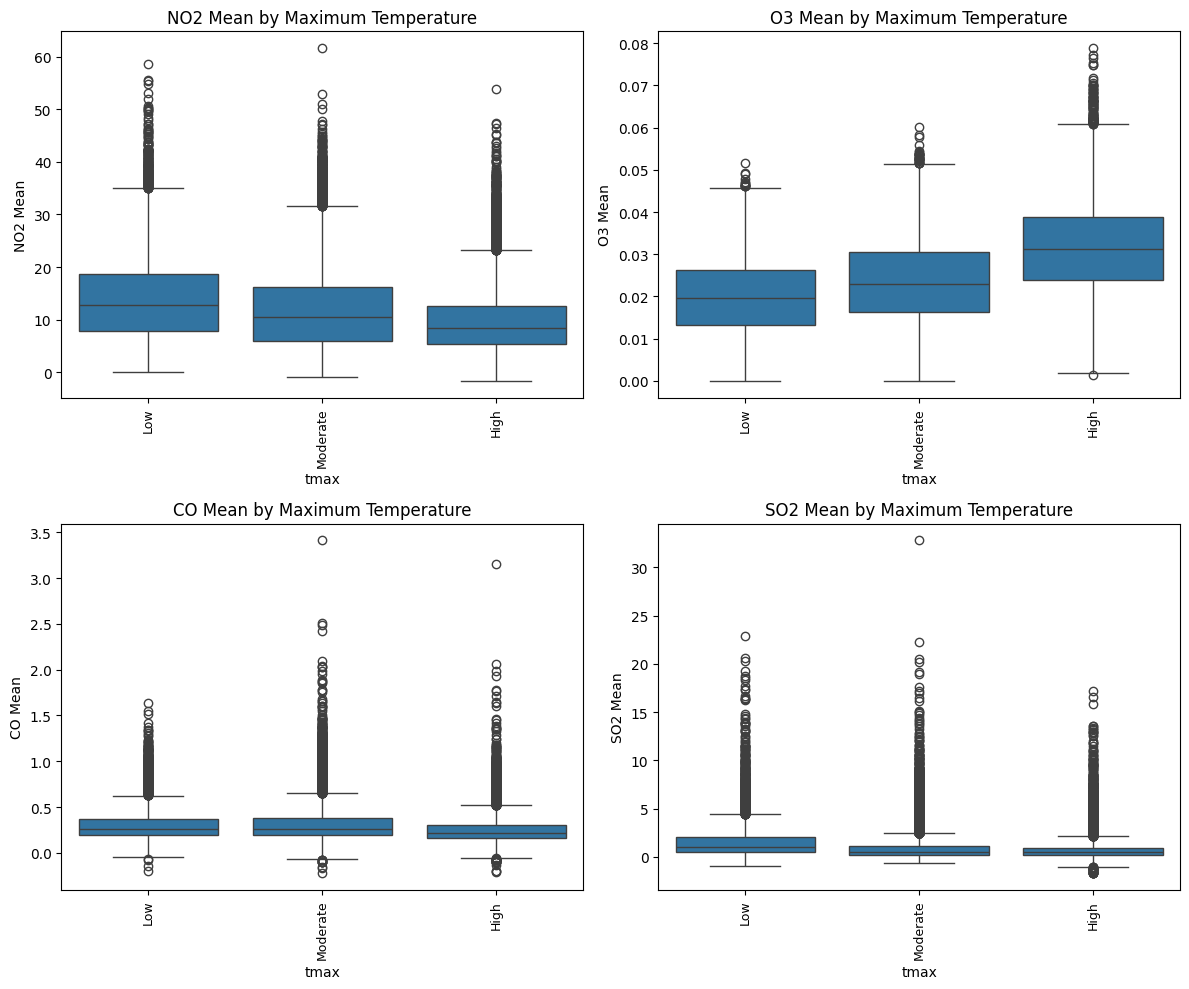

In [14]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Grid size
n = len(pollutants)
ncols = 2
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5*nrows))
axes = axes.flatten()

for idx, col in enumerate(pollutants):
    sns.boxplot(
        x="tmax_bin",
        y=col,
        data=df,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{col} by Maximum Temperature")
    axes[idx].set_xlabel("tmax")
    axes[idx].set_ylabel(col)
    axes[idx].tick_params(axis="x", rotation=90, labelsize=9)

# Hide unused subplots (if any)
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

I can see that while O3 increases with maximum temperature, all other pollutants tend to decrease. For NO2, the decrease is step-wise, while for CO, there doesn't appear to be a great difference in the medians for "Low" and "Moderate", but there is a decrease from "Moderate" to "High". For SO2, There is a decrease from "Low" to "Moderate", but not an apparent difference between "Moderate" and "High".

Next, I will use the non-parametric, Kruskal-Wallis test to assess whether the distributions are significantly different i.e. if each pollutants' mean levels are affected by maximum temperature. The null hypothesis states there are no differences, while the alternate, which can be accepted if p < 0.05, states that they are different.

In [15]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Initialize results list
kruskal_results = []

for col in pollutants:
    try:
        # Run Kruskal-Wallis test
        result = pg.kruskal(data=df, dv=col, between="tmax_bin")
        
        # Append results with the variable name
        kruskal_results.append({
            'variable': col,
            'H': result['H'].iloc[0],          # test statistic
            'pval': result['p-unc'].iloc[0]    # p-value
        })
    except Exception as e:
        print(f"Could not run Kruskal-Wallis for {col}: {e}")
        kruskal_results.append({
            'variable': col,
            'H': None,
            'pval': None
        })

# Convert results to DataFrame
kruskal_df = pd.DataFrame(kruskal_results).sort_values(by='pval').reset_index(drop=True)

kruskal_df

,variable,H,pval
0,NO2 Mean,2466.313081,0.0
1,O3 Mean,9569.411280,0.0
2,CO Mean,1473.274627,0.0
3,SO2 Mean,2924.409713,0.0


As p < 0.05 for each pollutant, I can accept the alternate hypothesis; the pollutants' mean levels are affected by maximum temperature.

As there is a correlation between mean values and maximum values, and a very tight correlation between maximum values and AQI. I will not be repeating the tests with those values.

---

## Pollutant Levels and Precipitation

Next, I am going to look at the effect of precipitation on pollutant levels. The bins will be "None" (0 - 0.1 mm), "Light" (0.1 - 5 mm), "Moderate" (5 - 20 mm), "Heavy" (20 - 50 mm) and "Very Heavy" (50 - 350 mm). Again, these bins have been chosen as they are meaningful and intuitive.

In [18]:
bins = [0, 0.1, 5, 20, 50, 350]
labels = ["None", "Light", "Moderate", "Heavy", "Very Heavy"]

df["prcp_bin"] = pd.cut(df["prcp"], bins=bins, labels=labels, include_lowest=True)

Here, I plot the box plots for each pollutant.

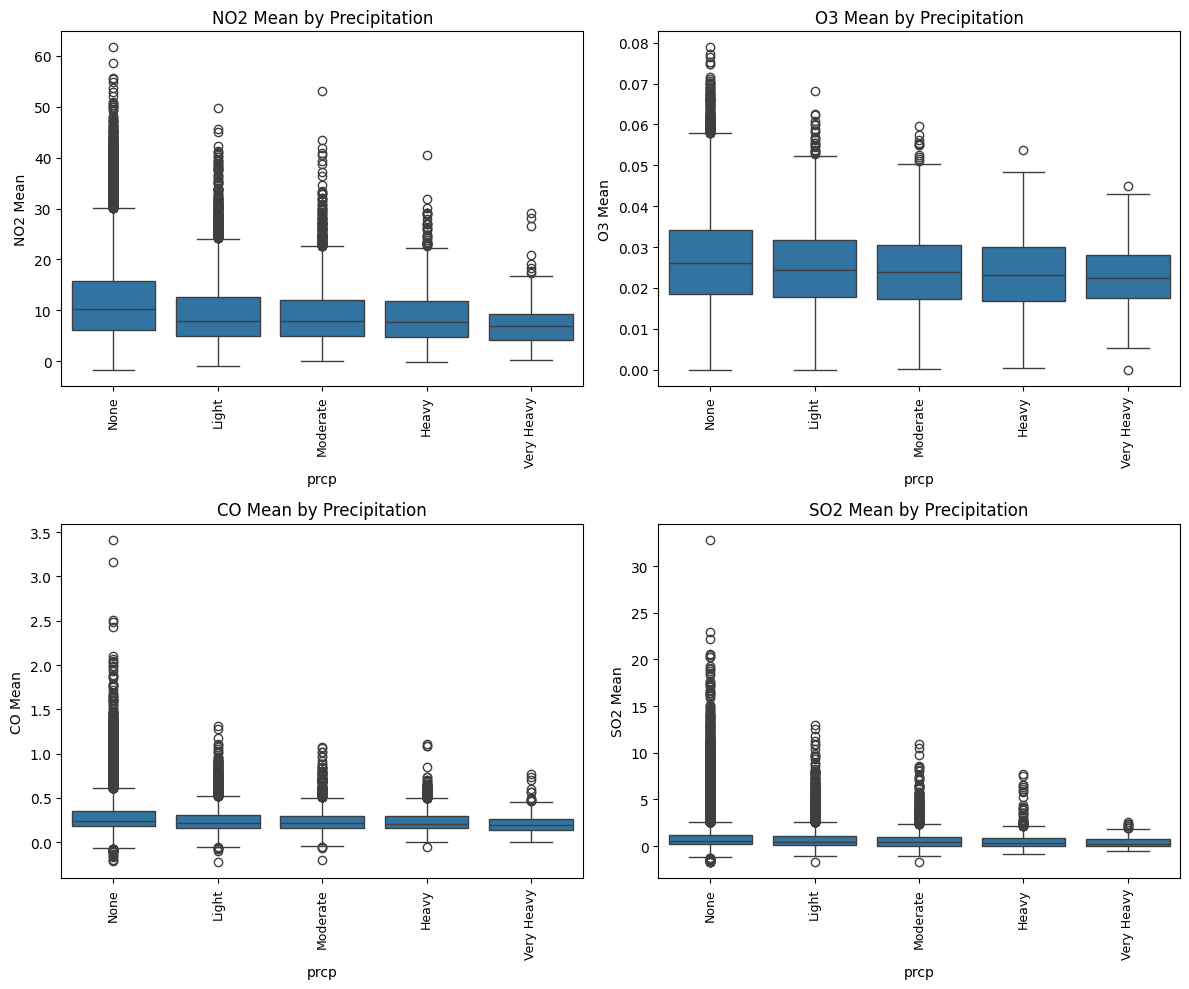

In [21]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Grid size
n = len(pollutants)
ncols = 2
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5*nrows))
axes = axes.flatten()

for idx, col in enumerate(pollutants):
    sns.boxplot(
        x="prcp_bin",
        y=col,
        data=df,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{col} by Precipitation")
    axes[idx].set_xlabel("prcp")
    axes[idx].set_ylabel(col)
    axes[idx].tick_params(axis="x", rotation=90, labelsize=9)

# Hide unused subplots (if any)
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

For NO2 and O3, it is easier to see the decrease in mean levels as precipitation increases, because the variance is greater (bigger box). For CO and SO2, the decrease is much less apparent due to the very small boxes, indicating much lower variance.

Below, I again perform non-parametric testing to assess for statistical differences between the distribution of mean pollutant levels by precipitation. 

In [20]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Initialize results list
kruskal_results = []

for col in pollutants:
    try:
        # Run Kruskal-Wallis test
        result = pg.kruskal(data=df, dv=col, between="prcp_bin")
        
        # Append results with the variable name
        kruskal_results.append({
            'variable': col,
            'H': result['H'].iloc[0],          # test statistic
            'pval': result['p-unc'].iloc[0]    # p-value
        })
    except Exception as e:
        print(f"Could not run Kruskal-Wallis for {col}: {e}")
        kruskal_results.append({
            'variable': col,
            'H': None,
            'pval': None
        })

# Convert results to DataFrame
kruskal_df = pd.DataFrame(kruskal_results).sort_values(by='pval').reset_index(drop=True)

kruskal_df

,variable,H,pval
0,NO2 Mean,1166.356033,3.130045e-251
1,CO Mean,551.946960,3.878632e-118
2,SO2 Mean,504.542151,6.976693e-108
3,O3 Mean,353.747589,2.721442e-75


As p < 0.05 for all pollutants, I can accept the alternate hypothesis that there are statistically significant differences between mean pollutant levels dependant on precipitation levels.

---

## Pollutant Levels by Wind Speed

Next, I will look at wind speed. The bins being used again reflect an inuitive and meaningful differentiation of wind speed: "Light" (0 - 10 km/ h); "Moderate" (10 - 30 km/ h); and "Strong" (30 - 60 km/ h).

In [22]:
bins = [0, 10, 30, 60]
labels = ["Light", "Moderate", "Strong"]

df["wspd_bin"] = pd.cut(df["wspd"], bins=bins, labels=labels, include_lowest=True)

Now, I plot each pollutants' mean values by wind speed category. 

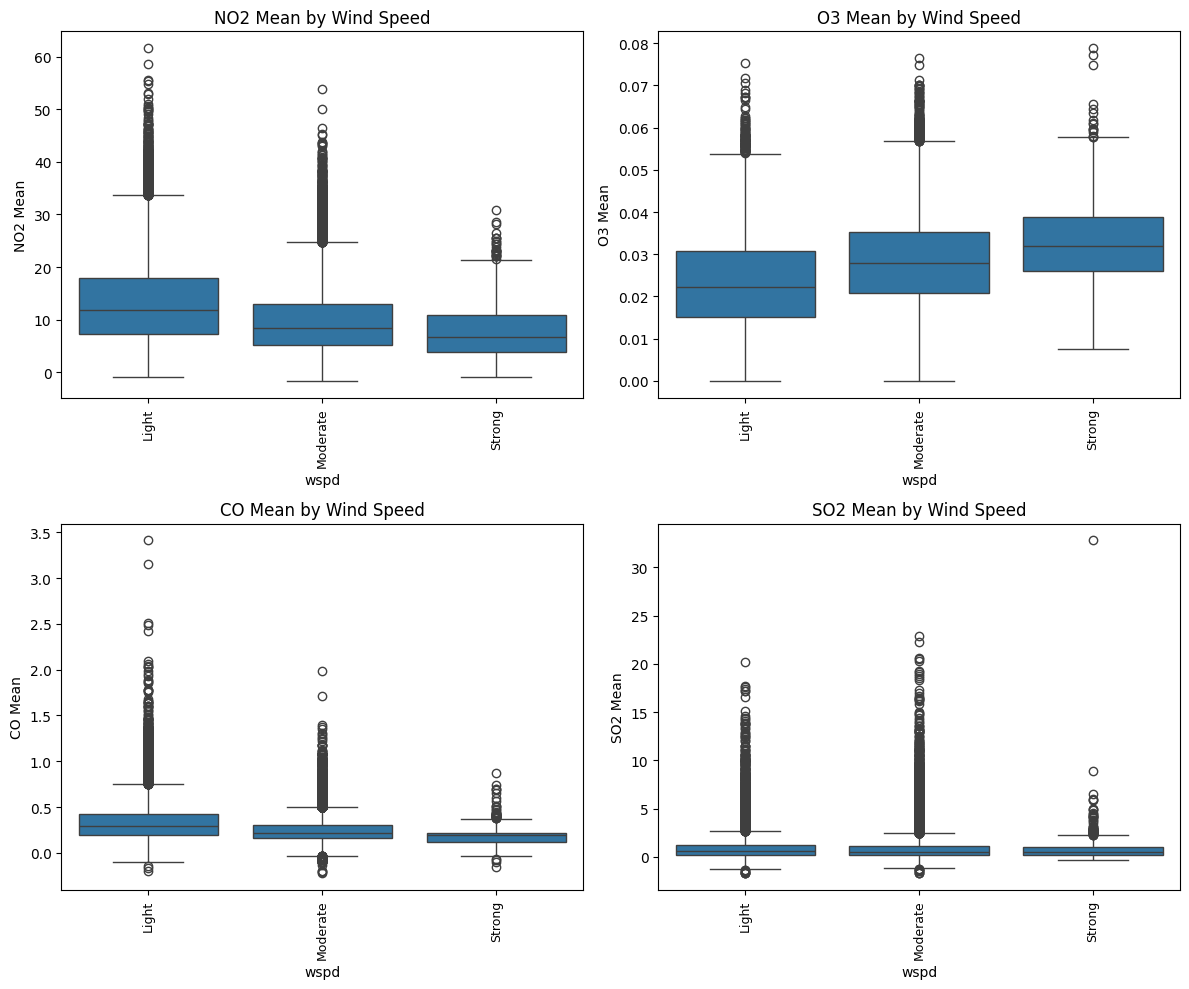

In [23]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Grid size
n = len(pollutants)
ncols = 2
nrows = math.ceil(n / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5*nrows))
axes = axes.flatten()

for idx, col in enumerate(pollutants):
    sns.boxplot(
        x="wspd_bin",
        y=col,
        data=df,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{col} by Wind Speed")
    axes[idx].set_xlabel("wspd")
    axes[idx].set_ylabel(col)
    axes[idx].tick_params(axis="x", rotation=90, labelsize=9)

# Hide unused subplots (if any)
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Similar to maximum temperature, I can see that increasing wind speed decreases the mean levels of each pollutant except for O2, which increases with wind speed. The relationship with wind speed apepars to be least strong for SO2.

Below, I will use the non-parametric Kruskal-Wallis test to check for statistical significance between the distributions of mean pollutant values wind speed. The hull hypothesis is that there are no differences, while the alternate is that there are.

In [24]:
pollutants = ['NO2 Mean', 'O3 Mean', 'CO Mean', 'SO2 Mean']

# Initialize results list
kruskal_results = []

for col in pollutants:
    try:
        # Run Kruskal-Wallis test
        result = pg.kruskal(data=df, dv=col, between="wspd_bin")
        
        # Append results with the variable name
        kruskal_results.append({
            'variable': col,
            'H': result['H'].iloc[0],          # test statistic
            'pval': result['p-unc'].iloc[0]    # p-value
        })
    except Exception as e:
        print(f"Could not run Kruskal-Wallis for {col}: {e}")
        kruskal_results.append({
            'variable': col,
            'H': None,
            'pval': None
        })

# Convert results to DataFrame
kruskal_df = pd.DataFrame(kruskal_results).sort_values(by='pval').reset_index(drop=True)

kruskal_df

,variable,H,pval
0,NO2 Mean,3478.262236,0.000000e+00
1,O3 Mean,3347.232282,0.000000e+00
2,CO Mean,4048.860530,0.000000e+00
3,SO2 Mean,104.465180,2.068590e-23


Once again, p < 0.05 for all pollutants, indicating I can accept the alternate hypothesis; mean pollutant levels vary depending on wind speed.

---

# Conclusion and Next Steps

* I have found that each pollutant varies depending on maximum temperature, precipitation and wind speed
* O3, in exception to the other pollutants, increase with increasing temperature and wind speed
* All 4 pollutants decrease with increasing precipitation
* Next, I will investigate hypothesis 3 - pollutant levels follow seasonal patterns